In [90]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

# pd.set_option()

# https://medium.com/@natalia.gcvs/regress%C3%A3o-log%C3%ADstica-uma-vis%C3%A3o-geral-de-uma-t%C3%A9cnica-de-classifica%C3%A7%C3%A3o-bin%C3%A1ria-eba0a4a06518
# 1 = indadimplente (evento)
# 0 = adimplente (nao evento)
# fazer quantidade de operações por mês como analise descritiva também ( da para fazer um grafico)
# quantidade de operações por genero, localizacao...
# https://www.youtube.com/watch?v=lK8ANM7VkNU , ideia de fazer um novo score-credito

# Dados

In [78]:
df = pd.read_excel('dados_case.xlsx', sheet_name='dados')
df2 = df.copy()
df2.head(10)

,Cliente,Safra,idade,genero,renda,Score_de_credito,localizacao,nivel_escolaridade,contas_bancarias,Contratos,Faixa_renda,Faixa_idade,Faixa_Score,Atraso_apos_6meses
0,1,202201,24,Masculino,8909.21,381,Norte,Médio,4,1,6001-10000,18-25,Até 400,0
1,2,202201,44,Masculino,1865.28,498,Norte,Médio,2,1,Até 2000,36-50,401-500,0
2,3,202204,25,Feminino,6699.76,541,Sul,Pós-graduação,0,1,6001-10000,18-25,501-600,0
3,4,202203,30,Feminino,5315.94,674,Oeste,Fundamental,2,1,4001-6000,26-35,601-700,0
4,5,202201,42,Feminino,7724.09,483,Norte,Pós-graduação,2,1,6001-10000,36-50,401-500,0
5,6,202203,41,Feminino,1904.76,713,Sul,Pós-graduação,4,1,Até 2000,36-50,701-800,0
6,7,202204,48,Feminino,3947.58,423,Sul,Pós-graduação,3,1,2001-4000,36-50,401-500,0
7,8,202203,19,Masculino,7332.81,736,Leste,Médio,1,1,6001-10000,18-25,701-800,0
8,9,202203,55,Masculino,6517.82,740,Leste,Pós-graduação,2,1,6001-10000,51-70,701-800,0
9,10,202201,57,Feminino,6777.68,330,Oeste,Médio,3,1,6001-10000,51-70,Até 400,1


# Sem correlação nas variáveis independentes, ou seja, sem multicolinearidade

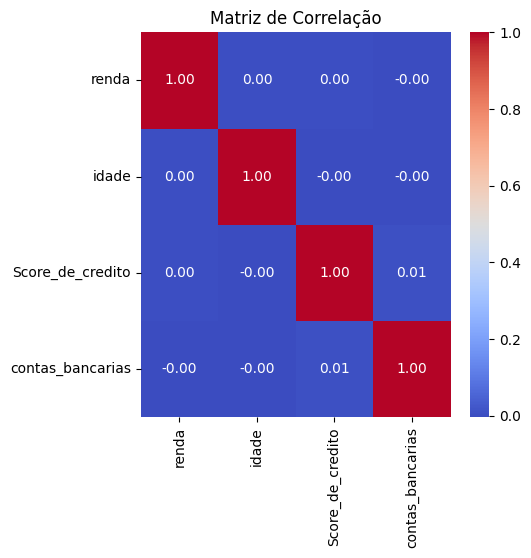

In [79]:
matriz = df2[['renda','idade','Score_de_credito','contas_bancarias']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(matriz, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

# Taxa de inadimplência atual
### Considerando atraso apos 6 meses de contrato:
.: Taxa de 6.65%, portanto superior a 5% concluindo que está prejudicial para a saúde operacional da empresa.

In [80]:
total_linhas = len(df2)
total_atraso = len(df2[df2['Atraso_apos_6meses']==1])

tx_atual = total_atraso/total_linhas

print(f"Taxa de inadimplencia hoje: {tx_atual*100}%")

Taxa de inadimplencia hoje: 6.65%


### Considerando o score de crédito
 - maior que 600 = aprovado
 - menor ou igual a 500 = nao aprovado

In [81]:
tx_df2_600 = len(df2[(df2['Score_de_credito']>600) & (df2['Atraso_apos_6meses']==1)]) / len(df2[(df2['Score_de_credito']>600)])
tx_df2_500 = len(df2[(df2['Score_de_credito']<=500) & (df2['Atraso_apos_6meses']==1)]) / len(df2[(df2['Score_de_credito']<=500)])


print(f"Taxa de inadimplencia com score acima de 600: {tx_df2_600 * 100} %")
print(f"Taxa de inadimplencia com score 500 ou menor: {tx_df2_500 * 100} %")

Taxa de inadimplencia com score acima de 600: 4.871122761031018 %
Taxa de inadimplencia com score 500 ou menor: 8.596300326441785 %


# Nova política de crédito
- tratar valores ausentes
- distribuicao
- outliers
- dummização (one hot enconding)
- padronização

In [21]:
for i in df.columns:
    resultado = df2[i].isna().unique()
    print(f"Coluna {i} apresenta valores faltantes: {resultado}")

Coluna Cliente apresenta valores faltantes: [False]
Coluna Safra apresenta valores faltantes: [False]
Coluna idade apresenta valores faltantes: [False]
Coluna genero apresenta valores faltantes: [False]
Coluna renda apresenta valores faltantes: [False]
Coluna Score_de_credito apresenta valores faltantes: [False]
Coluna localizacao apresenta valores faltantes: [False]
Coluna nivel_escolaridade apresenta valores faltantes: [False]
Coluna contas_bancarias apresenta valores faltantes: [False]
Coluna Contratos apresenta valores faltantes: [False]
Coluna Faixa_renda apresenta valores faltantes: [False]
Coluna Faixa_idade apresenta valores faltantes: [False]
Coluna Faixa_Score apresenta valores faltantes: [False]
Coluna Atraso_apos_6meses apresenta valores faltantes: [False]


# Padronização

In [28]:
scaler_standard = StandardScaler()
df_n_padronizado = df2[['renda', 'Score_de_credito']]
df_padronizado = scaler_standard.fit_transform(df_n_padronizado)

df2[['renda', 'Score_de_credito']] = pd.DataFrame(df_padronizado, columns=df_n_padronizado.columns)
df2

,Cliente,Safra,idade,genero,renda,Score_de_credito,localizacao,nivel_escolaridade,contas_bancarias,Contratos,Faixa_renda,Faixa_idade,Faixa_Score,Atraso_apos_6meses
0,1,202201,24,Masculino,1.302419,-1.228416,Norte,Médio,4,1,6001-10000,18-25,Até 400,0
1,2,202201,44,Masculino,-1.402809,-0.492234,Norte,Médio,2,1,Até 2000,36-50,401-500,0
2,3,202204,25,Feminino,0.453877,-0.221671,Sul,Pós-graduação,0,1,6001-10000,18-25,501-600,0
3,4,202203,30,Feminino,-0.077580,0.615186,Oeste,Fundamental,2,1,4001-6000,26-35,601-700,0
4,5,202201,42,Feminino,0.847272,-0.586616,Norte,Pós-graduação,2,1,6001-10000,36-50,401-500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,202203,70,Masculino,1.124430,-0.655830,Leste,Médio,0,1,6001-10000,51-70,401-500,0
9996,9997,202203,30,Masculino,-1.458032,0.111814,Oeste,Pós-graduação,1,1,Até 2000,26-35,501-600,0
9997,9998,202203,65,Feminino,0.717720,-1.184371,Oeste,Pós-graduação,0,1,6001-10000,51-70,Até 400,0
9998,9999,202204,58,Masculino,-0.734495,1.603055,Oeste,Pós-graduação,0,1,2001-4000,51-70,801-850,0


# Data

In [ ]:
df2['Safra'] = pd.to_datetime(df2['Safra'].astype(str), format='%Y%m')
df2['Safra'] = df2['Safra'].dt.strftime('%Y-%m-%d') 

# Dummização

In [52]:
df_encoded = pd.get_dummies(df2, columns=['genero','localizacao', 'nivel_escolaridade'], drop_first=True)
df_encoded = df_encoded.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
df_encoded.head(10)


,Cliente,Safra,idade,renda,Score_de_credito,contas_bancarias,Contratos,Faixa_renda,Faixa_idade,Faixa_Score,Atraso_apos_6meses,genero_Masculino,localizacao_Norte,localizacao_Oeste,localizacao_Sul,nivel_escolaridade_Médio,nivel_escolaridade_Pós-graduação,nivel_escolaridade_Superior
0,1,2022-01-01,24,1.302419,-1.228416,4,1,6001-10000,18-25,Até 400,0,1,1,0,0,1,0,0
1,2,2022-01-01,44,-1.402809,-0.492234,2,1,Até 2000,36-50,401-500,0,1,1,0,0,1,0,0
2,3,2022-04-01,25,0.453877,-0.221671,0,1,6001-10000,18-25,501-600,0,0,0,0,1,0,1,0
3,4,2022-03-01,30,-0.077580,0.615186,2,1,4001-6000,26-35,601-700,0,0,0,1,0,0,0,0
4,5,2022-01-01,42,0.847272,-0.586616,2,1,6001-10000,36-50,401-500,0,0,1,0,0,0,1,0
5,6,2022-03-01,41,-1.387647,0.860580,4,1,Até 2000,36-50,701-800,0,0,0,0,1,0,1,0
6,7,2022-04-01,48,-0.603100,-0.964145,3,1,2001-4000,36-50,401-500,0,0,0,0,1,0,1,0
7,8,2022-03-01,19,0.697001,1.005300,1,1,6001-10000,18-25,701-800,0,1,0,0,0,1,0,0
8,9,2022-03-01,55,0.384003,1.030469,2,1,6001-10000,51-70,701-800,0,1,0,0,0,0,1,0
9,10,2022-01-01,57,0.483803,-1.549316,3,1,6001-10000,51-70,Até 400,1,0,0,1,0,1,0,0


In [53]:
var_ind = df_encoded.drop(['Safra','Atraso_apos_6meses','Faixa_renda', 'Faixa_idade','Faixa_Score'], axis=1)
var_dep = df_encoded['Atraso_apos_6meses']

In [69]:
var_ind_treino, var_ind_teste, var_dep_treino, var_dep_teste = train_test_split(var_ind, var_dep, test_size=0.3, random_state=123)

modelo = LogisticRegression(C=1e10, solver='liblinear', random_state=456)

modelo.fit(var_ind_treino, var_dep_treino)
# print(f"coeficientes: {modelo.coef_[0]}")

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10000000000.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,456
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
var_ind_treino_const = sm.add_constant(var_ind_treino)

# Ajustar o modelo com statsmodels (por padrao nao usa regularizacao(penalidade))
modelo_stats = sm.Logit(var_dep_treino, var_ind_treino_const)
resultado = modelo_stats.fit()
resultado.summary()

Optimization terminated successfully.
         Current function value: 0.237266
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Atraso_apos_6meses   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6987
Method:                           MLE   Df Model:                           12
Date:                Thu, 19 Jun 2025   Pseudo R-squ.:                 0.01814
Time:                        17:30:05   Log-Likelihood:                -1660.9
converged:                       True   LL-Null:                       -1691.6
Covariance Type:            nonrobust   LLR p-value:                 1.262e-08
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Cliente                           2.519e-06   1.68e-05      0.150      0.881   -3.05e-05    3.55e-05
idade                                0.0039      0.003      1.221      0.222      -0.002       0.010
renda                               -0.0508      0.049     -1.044      0.297      -0.146       0.045
Score_de_credito                    -0.2955      0.050     -5.944      0.000      -0.393      -0.198
contas_bancarias                    -0.0408      0.035     -1.179      0.238      -0.109       0.027
Contratos                           -2.6825      0.242    -11.079      0.000      -3.157      -2.208
genero_Masculino                    -0.0245      0.097     -0.252      0.801      -0.215       0.166
localizacao_Norte                    0.1987      0.166      1.199      0.231      -0.126       0.523
localizacao_Oeste                    0.1619      0.155      1.046      0.295      -0.141       0.465
localizacao_Sul                      0.0657      0.178      0.368      0.713      -0.284       0.415
nivel_escolaridade_Médio            -0.0485      0.137     -0.355      0.723      -0.317       0.220
nivel_escolaridade_Pós-graduação    -0.4630      0.119     -3.876      0.000      -0.697      -0.229
nivel_escolaridade_Superior         -0.3913      0.163     -2.398      0.016      -0.711      -0.072
====================================================================================================
"""

# Validacação logit

In [87]:
var_ind_teste_const = sm.add_constant(var_ind_teste)
y_pred_prob = resultado.predict(var_ind_teste_const)

y_pred = (y_pred_prob >= 0.5).astype(int)

In [84]:
# 1. Acurácia
accuracy = accuracy_score(var_dep_teste, y_pred)
print(f"Acurácia: {accuracy * 100:.2f}%")

# 2. Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(var_dep_teste, y_pred)
print(cm)

# 3. Relatório de Classificação (Precision, Recall, F1-Score)
print("\nRelatório de Classificação:")
print(classification_report(var_dep_teste, y_pred))

# 4. AUC-ROC (Área sob a Curva ROC)
roc_auc = roc_auc_score(var_dep_teste, y_pred_prob)
print(f"\nAUC-ROC: {roc_auc:.2f}")

Acurácia: 93.10%

Matriz de Confusão:
[[2793    0]
 [ 207    0]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2793
           1       0.00      0.00      0.00       207

    accuracy                           0.93      3000
   macro avg       0.47      0.50      0.48      3000
weighted avg       0.87      0.93      0.90      3000


AUC-ROC: 0.59


c:\Users\joao.pinheiro\AppData\Local\anaconda3\envs\case_credito\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\joao.pinheiro\AppData\Local\anaconda3\envs\case_credito\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\joao.pinheiro\AppData\Local\anaconda3\envs\case_credito\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

Métricas de Avaliação
1. Acurácia (Accuracy): 93%
Acurácia é a proporção de previsões corretas (verdadeiros positivos e verdadeiros negativos) sobre o total de previsões. Uma acurácia de 93% indica que o modelo acertou 93% das previsões, mas isso pode ser enganoso quando as classes são desbalanceadas.

2. CI de 95% (Intervalo de Confiança): (0.9203, 0.9389)
Este é o intervalo de confiança para a acurácia do modelo, que indica que, com 95% de certeza, a verdadeira acurácia do modelo está entre 92.03% e 93.89%.

3. No Information Rate (NIR): 93%
A No Information Rate (NIR) é a acurácia que você obteria ao simplesmente prever a classe mais prevalente em todos os casos. Ou seja, se você sempre prevesse a classe 0 (não inadimplente), a NIR seria de 93%.

O P-Value [Acc > NIR] de 0.5184 sugere que a acurácia do modelo não é estatisticamente superior à NIR, ou seja, o modelo pode não estar adicionando valor substancial em relação a sempre prever 0 (não inadimplente).

4. Kappa: 0
Kappa mede a acordo entre as previsões do modelo e os valores reais, levando em conta o que seria esperado por acaso. O valor 0 indica que o modelo não está melhor do que uma previsão aleatória.

5. Mcnemar's Test P-Value: <2e-16
O teste de McNemar é usado para verificar se o modelo tem um desbalanceamento nas classificações (i.e., se o modelo tende a prever uma classe de forma sistemática, mas não outra). O valor p extremamente pequeno (<2e-16) sugere que o modelo tem um viés claro em suas previsões (provavelmente devido ao desbalanceamento de classes).

Métricas de Classificação
6. Sensibilidade (Sensitivity): 1.00
Sensibilidade (também conhecida como recall ou true positive rate) mede a proporção de verdadeiros positivos corretamente identificados pelo modelo. Uma sensibilidade de 1.00 significa que o modelo identificou corretamente todos os casos de inadimplência (não houve falsos negativos).

7. Especificidade (Specificity): 0.00
Especificidade (também conhecida como true negative rate) mede a proporção de verdadeiros negativos corretamente identificados pelo modelo. Uma especificidade de 0.00 significa que o modelo não conseguiu identificar corretamente nenhum caso de não inadimplência (houve falsos positivos em todos os casos).

8. Valor Preditivo Positivo (Pos Pred Value): 0.93
Pos Pred Value (Precisão) mede a proporção de previsões positivas que são realmente positivas. Ou seja, em 93% das vezes que o modelo previu que o cliente seria inadimplente, ele estava correto.

# Random forest

In [88]:
# var_ind_treino, var_ind_teste, var_dep_treino, var_dep_teste

# Inicializar o modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=123)

# Ajustar o modelo
modelo_rf.fit(var_ind_treino, var_dep_treino)

# Fazer previsões nos dados de teste
y_pred = modelo_rf.predict(var_ind_teste)

# Avaliar o modelo
# Acurácia
acuracia = accuracy_score(var_dep_teste, y_pred)
print(f"Acurácia do Random Forest: {acuracia * 100:.2f}%")

# Matriz de Confusão
conf_matrix = confusion_matrix(var_dep_teste, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# AUC-ROC
y_pred_prob = modelo_rf.predict_proba(var_ind_teste)[:, 1]  # Probabilidade para a classe positiva (inadimplente)
roc_auc = roc_auc_score(var_dep_teste, y_pred_prob)
print(f"AUC-ROC do Random Forest: {roc_auc:.2f}")

Acurácia do Random Forest: 93.10%
Matriz de Confusão:
[[2793    0]
 [ 207    0]]
AUC-ROC do Random Forest: 0.55
